In [89]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import math
from math import sin as sin
from math import cos as cos
import time

In [90]:

# Main-Funktion
if __name__ == "__main__":

    std_0 = 1.0  # Std. für Beacon 0
    std_1 = 1.0  # Std. für Beacon 1
    std_2 = 1.0  # Std. für Beacon 2
    std_h = 1.0  # Std. für Kompass
    
    beacon0_pos = np.array([-15, 0])
    beacon1_pos = np.array([15, 0])
    beacon2_pos = np.array([-1, -5])

    samples = 100

    dT = 0.1

    np.random.seed(int(time.time()))
    

In [91]:
def f_x(state, dt):
    """
    Zustandsübergangsfunktion.
    Da die Geschwindigkeit konstant ist und der Zustand nur die Position beinhaltet,
    hat diese Funktion einfach die Geschwindigkeit zur Position hinzugefügt.
    TODO: Später Orientierungswinkel rein (und Winkel in der Messfunktion beachten)
    """  
    x, y, vx, vy, ax, ay = state

    # Update position with current velocity and acceleration
    new_x = x + vx * dt + (ax * dt ** 2) / 2.0
    new_y = y + vy * dt + (ay * dt ** 2) / 2.0

    # Update velocity with current acceleration
    new_vx = vx + ax * dt
    new_vy = vy + ay * dt

    # Speed stays constant (no acceleration yet)
    new_ax = ax
    new_ay = ay

    return np.array([new_x, new_y, new_vx, new_vy, new_ax, new_ay])

In [92]:
def h_x(state):

    def normalize_angle(x):
        x = x % (360)    # force in range [0, 360)
        if x > 180:          # move to [-180, 180)
            x -= 360
        return x

    """
    Messfunktion.
    Bildet den Zustandsraum (Position und Geschwindigkeit des Schiffs)
    auf den Messraum ab (Winkel von den Funktürmen), wobei definiert als:
    - Norden als 0°, 
    - Osten als 270°,
    - Süden als 180°,
    - Westen als 90°.
    """
    x, y, vx, vy, _, _ = state

    # Calculate angle (from the ship) to each beacon (converse from radians ->  angles)
    angleH = np.arctan2(vx, vy) * 180 / np.pi # heading in relation to north (0.0, 1.0)
    angleH = normalize_angle(angleH)
    angle0 = np.arctan2(beacon0_pos[0] - x, beacon0_pos[1] - y) * 180 / np.pi
    angle0 = normalize_angle(angle0)
    angle1 = np.arctan2(beacon1_pos[0] - x, beacon1_pos[1] - y) * 180 / np.pi
    angle1 = normalize_angle(angle1)
    angle2 = np.arctan2(beacon2_pos[0] - x, beacon2_pos[1] - y) * 180 / np.pi
    angle2 = normalize_angle(angle2)

    return np.array([-angle0, -angle1, - angle2, -angleH]) # flip signs for correct mathematicaly representation

In [93]:
# Berechne die echten Status der ersten 10 Sekunden, das Schiff fährt Kurven, Geschwindigkeit nicht konstant

states = [] # pos_x, pos_y, vel_x, vel_y, acc_x, acc_y (constatn acceleration model, actually not, because direction is changing)

x = 0
y = 0
vx = 0
vy = 0
ax = 0
ay = 0

for i in range(samples):

    x = 5 * sin(i * dT)
    y = -10 + 2 * i * dT

    if(i != 0): # calculate velocity of previous state with position of current state
        states[i - 1][2] = (x - states[i - 1][0]) / dT
        states[i - 1][3] = (y - states[i - 1][1]) / dT
        vx = states[i - 1][2]
        vy = states[i - 1][3]

    states.append(np.array([x, y, vx, vy, ax, ay]))


In [94]:
# Berechne die verrauschten Messdaten

zs = []

for i in range(samples):
    h = h_x(states[i]) # winkel beacon0, winkel beacon_1, winkel beacon_2, heading
    zs.append([h[0] + np.random.randn() * std_0, h[1] + np.random.randn() * std_1, h[2] + np.random.randn() * std_2, h[3] + np.random.randn() * std_h])

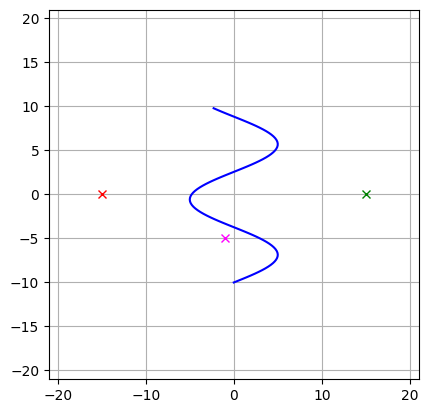

In [95]:
# visualisiere echten Zustand

x_val = [s[0] for s in states]
y_val = [s[1] for s in states]

fig, ax = plt.subplots()
plt.xlim(-21, 21)
plt.ylim(-21, 21)
ax.set_aspect('equal')

plt.plot(x_val, y_val, color = 'blue')

plt.plot(beacon0_pos[0], beacon0_pos[1], marker = 'x', color='red')
plt.plot(beacon1_pos[0], beacon1_pos[1], marker = 'x', color='green')
plt.plot(beacon2_pos[0], beacon2_pos[1], marker = 'x', color='magenta')

plt.grid(True)

plt.show()

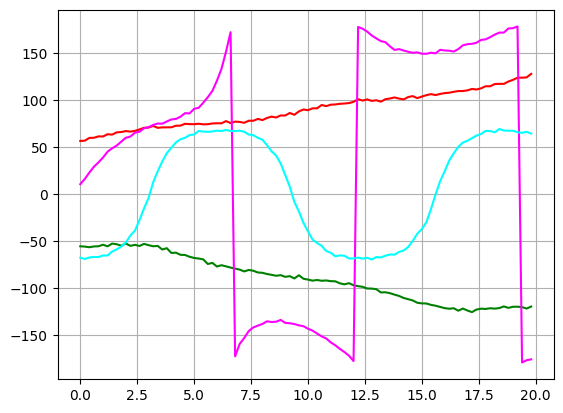

In [96]:
# visualisiere messdaten (diese sind verrauscht)

beacon0_val = [z[0] for z in zs]
beacon1_val = [z[1] for z in zs]
beacon2_val = [z[2] for z in zs]
heading_val = [z[3] for z in zs]
t = [(2 * i * dT) for i in range(samples)]

plt.plot(t, beacon0_val, color = 'red')
plt.plot(t, beacon1_val, color = 'green')
plt.plot(t, beacon2_val, color = 'magenta')
plt.plot(t, heading_val, color = 'cyan')
plt.grid(True)
plt.show()

In [97]:
# UKF

sigmas = MerweScaledSigmaPoints(n = 6, alpha = 0.1, beta = 2.0, kappa = 1.0)

ukf = UKF(dim_x = 6, dim_z = 4, fx = f_x, hx = h_x, dt = dT, points = sigmas)

ukf.x = states[0].copy()
ukf.R = np.diag([std_0 ** 2, std_1 ** 2, std_2 ** 2, std_h ** 2])
ukf.Q = Q_discrete_white_noise(dim = 2, dt = dT, var = 0.02, block_size = 3, order_by_dim = False)

In [98]:
# bereche position mit UKF

uxs = []

temp = ukf.x.copy()

for z in zs:

    ukf.predict()
    ukf.update(z)

    uxs.append(ukf.x.copy())

uxs = np.array(uxs)

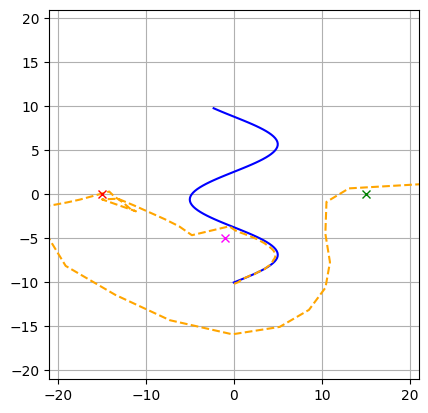

In [99]:
# visualisiere gefilterten Zustand

x_val = [s[0] for s in states]
y_val = [s[1] for s in states]

ux_val = [s[0] for s in uxs]
uy_val = [s[1] for s in uxs]

fig, ax = plt.subplots()
plt.xlim(-21, 21)
plt.ylim(-21, 21)
ax.set_aspect('equal')

plt.plot(x_val, y_val, color = 'blue')
plt.plot(ux_val, uy_val, color = 'orange', linestyle='--')

plt.plot(beacon0_pos[0], beacon0_pos[1], marker = 'x', color='red')
plt.plot(beacon1_pos[0], beacon1_pos[1], marker = 'x', color='green')
plt.plot(beacon2_pos[0], beacon2_pos[1], marker = 'x', color='magenta')

plt.grid(True)

plt.show()